In [1]:
import iris
import os
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

iris.FUTURE.netcdf_promote = True
%matplotlib inline

In [2]:
# from multiprocessing import Pool
# p = Pool(5)

In [57]:
def list_mogreps_uk(folder, years, months, days, hours, fcsts):
    fs = ['prods_op_mogreps-uk_{:04d}{:02d}{:02d}_{:02d}_00_{:03d}.nc'.format(year, month, day, hour, fcst)
            for year in years for month in months for day in days for hour in hours for fcst in fcsts]
    fs = [os.path.join(folder,f) for f in fs]
    return fs
    
class PrecipZoomoutDataset():
    def __init__(self, filenames):
        filenames.sort()
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        precip = iris.load(self.filenames[idx], 
                           'low_type_cloud_area_fraction')[0][0]
        precip = precip[-480:, :384]
        
        lrs = []
        for scale_factor in [8,16,24,32,48]:
            low_res = np.add.reduceat(np.add.reduceat(precip.data, 
                                                      list(range(0, precip.data.shape[0], scale_factor))),
                                      list(range(0, precip.data.shape[1], scale_factor)), 
                                      axis=1) / scale_factor ** 2

            low_res_hr = low_res.repeat(scale_factor, 0).repeat(scale_factor, 1)
            val = low_res_hr
            lrs.append(val)

        return np.array(lrs + [precip.data])
    
class PrecipZoomout2Dataset():
    def __init__(self, array):
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, idx):
        precip = self.array[idx]
#         precip = precip[-480:, :384]
        
        lrs = []
        for scale_factor in [1,2,4,8,12]:
            low_res = np.add.reduceat(np.add.reduceat(precip.data, 
                                                      list(range(0, precip.data.shape[0], scale_factor))),
                                      list(range(0, precip.data.shape[1], scale_factor)), 
                                      axis=1) / scale_factor ** 2

            low_res_hr = low_res.repeat(scale_factor, 0).repeat(scale_factor, 1)
            val = low_res_hr
            lrs.append(val)

        return np.array(lrs)
    
class ArrayOffsetsDataset():
    def __init__(self, array):
        self.array = array

    def __len__(self):
        return len(self.array)

    def __getitem__(self, idx):
        array = self.array[idx]

        offsets = [
            array,
            np.concatenate([np.zeros([1, array[1:].shape[1]]), array[1:]]),
            np.concatenate([array[:-1], np.zeros([1, array[:-1].shape[1]])]),
            np.concatenate([np.zeros([array[:,1:].shape[0], 1]), array[:,1:]], axis=1),
            np.concatenate([array[:,:-1], np.zeros([array[:,:-1].shape[0], 1])], axis=1)
        ]

        return np.array(offsets)
        
class ArrayZoomoutDataset():
    def __init__(self, array, scale_factors=[8,16,24,32,48,4], subset=(slice(None), slice(None)), target=4):
        self.array = array
        self.scale_factors = scale_factors
        self.subset = subset
        self.target = target

    def __len__(self):
        return len(self.array)

    def __getitem__(self, idx):
        array = self.array[idx][self.subset]
        
        lrs = []
        for scale_factor in self.scale_factors:
            for op in [np.add, np.minimum, np.maximum]:
                low_res = op.reduceat(op.reduceat(array, 
                                                          list(range(0, array.shape[0], scale_factor))),
                                          list(range(0, array.shape[1], scale_factor)), 
                                          axis=1) 
                if op == np.add:
                    low_res == low_res / scale_factor ** 2

                low_res_hr = low_res.repeat(
                                            scale_factor/self.target, 0
                                           ).repeat(scale_factor/self.target, 1)
                lrs.append(low_res_hr)

        return np.array(lrs)
    
class CloudDataset():
    def __init__(self, filenames):
        filenames.sort()
        self.filenames = filenames

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        cube = iris.load(self.filenames[idx], 
                           'low_type_cloud_area_fraction')[0][0]

        return cube.data

In [58]:
arrays = np.load('data/cloud_data.npz')

target_factor = 4

input_data = arrays['data']
input_array = np.array(list(ArrayZoomoutDataset(input_data, [8,16,24,32,48,4],
                                                subset=(slice(-480, None), slice(0,384)))))

test_data = arrays['test']
test_array = np.array(list(ArrayZoomoutDataset(test_data, [8,16,24,32,48,4],
                                               subset=(slice(-480, None), slice(0,384)))))

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [60]:
def train(coords):
    lat = coords[0]
    lon = coords[1]
    lr = LinearRegression()
    sample = np.random.randint(len(input_array), size=100)
    lr.fit(input_array[sample,:-1,lat,lon], input_array[sample,-1,lat,lon])
    return lr

In [61]:
a = 480 // target_factor
b = 384 // target_factor

In [62]:
%%time
i_coords, j_coords = np.meshgrid(range(a), range(b), indexing='ij')
grid = np.swapaxes(np.array([i_coords, j_coords]), 0, -1).reshape([-1,2])

uk_model = np.array([train(x) for x in grid.tolist()])

CPU times: user 13.5 s, sys: 148 ms, total: 13.6 s
Wall time: 6.81 s


In [63]:
def predict(arr):
    return np.array(
        [uk_model[i].predict(arr.reshape([-1, a*b])[:-1,i].reshape([1,-1])) for i in range(uk_model.shape[0])]
    ).reshape([a, b])

In [64]:
%%time
sample = np.random.randint(len(input_array), size=600)
inp2 = np.array([predict(d) for d in input_array[sample]])

CPU times: user 3min 2s, sys: 2.14 s, total: 3min 4s
Wall time: 2min 59s


In [65]:
# np.stack(input_array2, input_array[]

In [66]:
# input_array2 = np.array(list(ArrayZoomoutDataset(inp2, [4,8,12,16,24,4])))
input_array2 = np.array(list(ArrayZoomoutDataset(inp2, [1,2,3], target=0.5)))

In [67]:
def low_res(array, scale_factor):
    return np.add.reduceat(np.add.reduceat(array, 
                                          list(range(0, array.shape[1], scale_factor)), axis=1),
                          list(range(0, array.shape[2], scale_factor)), 
                          axis=2) / scale_factor ** 2

low_res_input_data = low_res(input_data[sample,-480:,:384], 2)

input_array2 = np.concatenate([input_array2, 
                               low_res_input_data.reshape([len(sample),1,240,-1])], axis=1)

In [68]:
def train2(coords):
    lat = coords[0]
    lon = coords[1]
    lr = LinearRegression()
    lr.fit(input_array2[:,:-1,lat,lon], input_array2[:,-1,lat,lon])
    return lr

In [69]:
%%time
i_coords, j_coords = np.meshgrid(range(low_res_input_data.shape[1]), 
                                 range(low_res_input_data.shape[2]), indexing='ij')
grid = np.swapaxes(np.array([i_coords, j_coords]), 0, -1).reshape([-1,2])

uk_model2 = np.array([train2(x) for x in grid.tolist()])

CPU times: user 52.9 s, sys: 756 ms, total: 53.7 s
Wall time: 26.8 s


In [70]:
uk_model[200].coef_

array([ -2.15846882e-03,   1.56260967e-01,   6.22249126e-01,
         1.62102748e-04,  -1.41812071e-01,  -2.65786707e-01,
         6.32703304e-04,   2.31197327e-02,  -1.02069974e-03,
        -1.23441219e-04,   6.00081235e-02,   8.94609019e-02,
        -4.81158495e-05,   4.21487540e-03,  -2.27975026e-02,
         5.85103631e-02,  -4.91423309e-01], dtype=float32)

In [71]:
uk_model2[200].coef_

array([ 0.48007008,  0.48007005,  0.48007011, -0.09992618,  0.18337618,
       -0.20242739, -0.01849551,  0.25716716, -0.12043568], dtype=float32)

In [72]:
n = 70

In [73]:
data = test_array[n].reshape([-1, a*b])

uk_preds = np.array(
    [uk_model[i].predict(data[:-1,i].reshape([1,-1])) for i in range(uk_model.shape[0])]
).reshape([a, b])

data2 = np.array(list(ArrayZoomoutDataset(uk_preds.reshape(1, a, b), [1,2,3], target=0.5))).reshape([-1, 240*192])

uk_preds2 = np.array(
    [uk_model2[i].predict(data2[:,i].reshape([1,-1])) for i in range(uk_model2.shape[0])]
).reshape([240, 192])

In [74]:
def low_res(array, scale_factor):
    return np.add.reduceat(np.add.reduceat(array, 
                                          list(range(0, array.shape[0], scale_factor))),
                          list(range(0, array.shape[1], scale_factor)), 
                          axis=1) / scale_factor ** 2

def high_res(array, scale_factor):
    return array.repeat(scale_factor, 0).repeat(scale_factor, 1)

target = low_res(test_data[n][-480:, :384], 2)

In [75]:
# np.mean(np.square(test_array[n][0] - test_array[n][-1]))
np.mean(np.square(high_res(test_array[n][0], 2) - target))

575.62482

In [76]:
# np.mean(np.square(uk_preds - test_array[n][-1]))

In [77]:
np.mean(np.square(uk_preds2 - target))

0.017741608

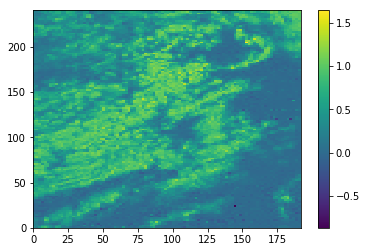

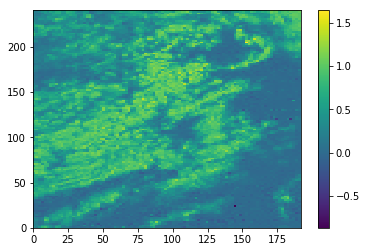

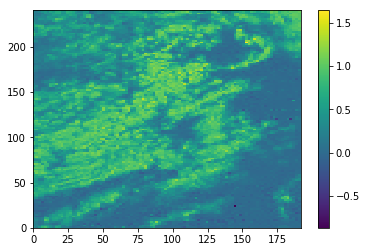

In [78]:
plt.pcolormesh(data2.reshape((9,240,192))[0]); plt.colorbar(); plt.show();
plt.pcolormesh(data2.reshape((9,240,192))[1]); plt.colorbar(); plt.show();
plt.pcolormesh(data2.reshape((9,240,192))[2]); plt.colorbar();

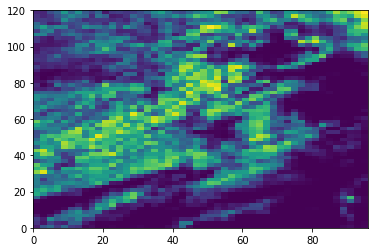

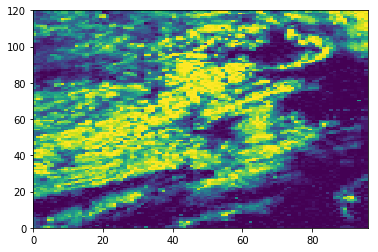

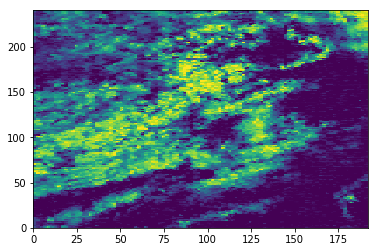

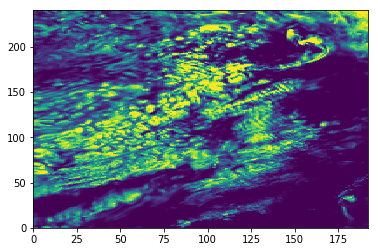

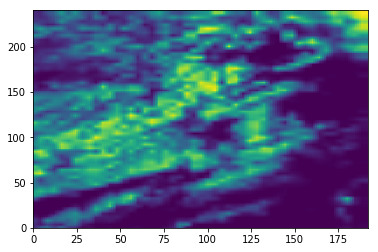

In [79]:
plt.pcolormesh(test_array[n][0]); plt.show();
plt.pcolormesh(uk_preds, vmin=0, vmax=1); plt.show();
plt.pcolormesh(uk_preds2, vmin=0, vmax=1); plt.show();
plt.pcolormesh(target); plt.show();
t = low_res(test_array[n][0], 2)
plt.pcolormesh(sp.interpolate.interp2d(np.arange(0,t.shape[1]*4,4), 
                                       np.arange(0,t.shape[0]*4,4), t)(
    np.arange(target.shape[1]), np.arange(target.shape[0])));

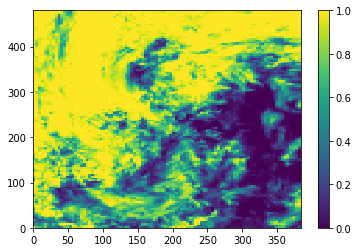

In [77]:
plt.pcolormesh(inpt_array[n][-1]); plt.colorbar();

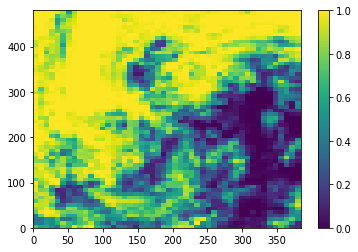

In [78]:
plt.pcolormesh(inpt_array[n][0]); plt.colorbar();

In [ ]:
plt.pcolormesh(inpt_array[n][0]); plt.colorbar();

In [41]:
5 * 96

480

In [42]:
4 * 96

384

In [4]:
iris.load(list_mogreps_uk('/home/ubuntu/sss/mogreps-uk', 
                                             [2016], 
                                             [5,6,7,8,9,10], 
                                             list(range(1,22)),
                                             [3,15],
                                             [3])[0])

[<iris 'Cube' of wet_bulb_potential_temperature / (K) (time: 4; pressure: 3; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of wet_bulb_freezing_level_altitude / (m) (time: 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of unknown_2 / (1) (time: 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of unknown_1 / (1) (time: 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of stratiform_snowfall_rate / (kg m-2 s-1) (time: 37; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of cloud_area_fraction_assuming_maximum_random_overlap / (1) (time: 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_2p5_oktas / (kft) (time: 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of unknown_0 / (1) (-- : 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of unknown / (1) (time: 4; grid_latitude: 548; grid_longitude: 421)>,
<iris 'Cube' of air_pressure_at_sea

In [6]:
l = list_mogreps_uk('/home/ubuntu/sss/mogreps-uk', 
                                             [2016], 
                                             [5,6,7,8,9,10], 
                                             list(range(1,22)),
                                             [3,15],
                                             [3])